In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time, warnings, pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import edward as ed
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from edward.models import Normal
warnings.simplefilter('ignore')

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
def build_toy_dataset():
    features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
    df = pd.read_csv('../winequality-white.csv', sep=';')
    X = df[features].values
    y = (df.quality >= 7).values.astype(np.float32)

    # 标准化处理
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)
    return X, y

def neural_network(X, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(X, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

def pack_theta(W_0, W_1, b_0, b_1):
    pW_0 = tf.reshape(W_0, [-1])
    pW_1 = tf.reshape(W_1, [-1])
    pb_0 = tf.reshape(b_0, [-1])
    pb_1 = tf.reshape(b_1, [-1])
    return tf.concat(values=[pW_0, pW_1, pb_0, pb_1], axis=0)

In [4]:
ed.set_seed(42)

J = 1000
B = 100
K = 20
# DATA
X_train, y_train = build_toy_dataset() #真实数据
N, D = X_train.shape
print(N, D)

4898 11


In [12]:
# MODEL
W_0 = Normal(loc=tf.zeros([D, 14]), scale=tf.ones([D, 14]),name="W_0")
W_1 = Normal(loc=tf.zeros([14, 1]), scale=tf.ones([14, 1]), name="W_1")
b_0 = Normal(loc=tf.zeros(14), scale=tf.ones(14), name="b_0")
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1), name="b_1")

X = tf.placeholder(tf.float32, [N, D], name="X")
y = Normal(loc=neural_network(X, W_0, W_1, b_0, b_1), scale=0.1 * tf.ones(N), name="y")

In [13]:
# INFERENCE FRAMEWORK
with tf.variable_scope("qW_0"):
    loc = tf.get_variable("loc", [D, 14])
    scale = tf.nn.softplus(tf.get_variable("scale", [D, 14]))
    qW_0 = Normal(loc=loc, scale=scale)
with tf.variable_scope("qW_1"):
    loc = tf.get_variable("loc", [14, 1])
    scale = tf.nn.softplus(tf.get_variable("scale", [14, 1]))
    qW_1 = Normal(loc=loc, scale=scale)
with tf.variable_scope("qb_0"):
    loc = tf.get_variable("loc", [14])
    scale = tf.nn.softplus(tf.get_variable("scale", [14]))
    qb_0 = Normal(loc=loc, scale=scale)
with tf.variable_scope("qb_1"):
    loc = tf.get_variable("loc", [1])
    scale = tf.nn.softplus(tf.get_variable("scale", [1]))
    qb_1 = Normal(loc=loc, scale=scale)

In [14]:
# Sample functions from variational model to visualize fits.
'''mus = tf.stack(
    [neural_network(X_train, qW_0.sample(), qW_1.sample(),
                       qb_0.sample(), qb_1.sample())
    for _ in range(B)])
'''
mus = tf.stack(
    [pack_theta(qW_0.sample(), qW_1.sample(),
                       qb_0.sample(), qb_1.sample())
    for _ in range(B)])

initializing the graph...
sampleing from prior of theta...
sampling time:  10.7531280518


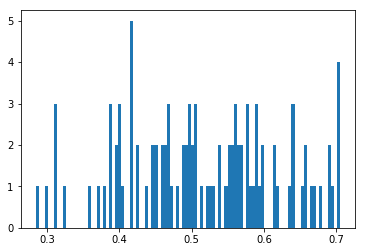

In [7]:
print("initializing the graph...")
start_sample = time.time()
sess = ed.get_session()
tf.global_variables_initializer().run()
print("sampleing from prior of theta...")
outputs = mus.eval()
print("sampling time: ", time.time() - start_sample)

s = []
for i in range(B):
    s.append(roc_auc_score(y_train,outputs[i]))
    
plt.hist(s, bins=100)
plt.show()

In [15]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                       W_1: qW_1, b_1: qb_1}, data={X: X_train, y: y_train})
inference.run(n_iter=J, n_samples=K)

1000/1000 [100%] ██████████████████████████████ Elapsed: 27s | Loss: 26135.258


In [12]:
outputs.shape

(100, 4898)

sampleing from posterior of theta...
sampling time:  0.0537738800049


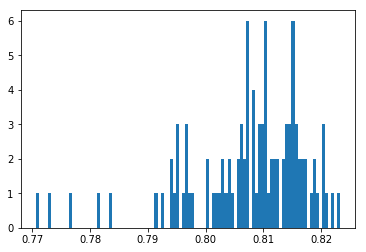

In [9]:
print("sampleing from posterior of theta...")
start_sample = time.time()
outputs = mus.eval()
print("sampling time: ", time.time() - start_sample)
sp = []
for i in range(B):
    sp.append(roc_auc_score(y_train,outputs[i]))
    
plt.hist(sp, bins=100)
plt.show()

In [16]:
import pickle
outputs = mus.eval()
with open('../smc2/theta'+'-'+str(J)+'-'+str(B),'wb') as f:
    pickle.dump(outputs, f)

In [5]:
with open('../smc2/theta'+'-'+str(J)+'-'+str(B),'rb') as f:
    outputs1 = np.array(pickle.load(f))

In [6]:
def np_neural_network(X, W_0, W_1, b_0, b_1):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.matmul(h, W_1) + b_1
    return np.reshape(h, [-1])

def unpack_thete_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*14], [11, 14])
    W_1 = np.reshape(theta[11*14: 11*14+14*1], [14, 1])
    b_0 = np.reshape(theta[11*14+14*1:11*14+14*1+14], [14])
    b_1 = np.reshape(theta[11*14+14*1+14:], [1])
    return np_neural_network(X, W_0, W_1, b_0, b_1)

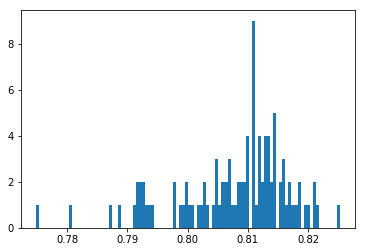

In [7]:
sp = []
for theta in outputs1:
    sp.append(roc_auc_score(y_train,unpack_thete_get_outputs(X_train, theta)))
plt.hist(sp, bins=100)
plt.show()

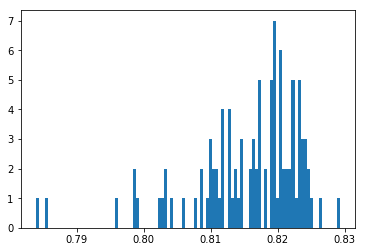

In [22]:
sp = []
for i in range(B):
    sp.append(roc_auc_score(y_train,unpack_thete_get_outputs(X_train, outputs[i])))
plt.hist(sp, bins=100)
plt.show()

In [12]:
plt.savefig

(1000, 11, 14)

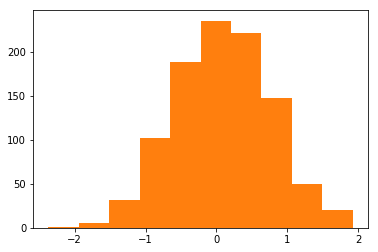

In [14]:
plt.hist(mya[:,0,0])
plt.show()

In [ ]:
saver = tf.train.Saver([])
with tf.Session() as sess:
    saver.